In [111]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors
import matplotlib.colorbar
import EpiClockInvasiveBRCA.src.util as epi_util
from EpiClockInvasiveBRCA.src.consts import consts
from sklearn.linear_model import ElasticNet

In [113]:
figure_outdir = 'figures'
if not os.path.exists(figure_outdir):
    os.mkdir(figure_outdir)

In [114]:
dataset_list = ['TCGA', 'Ringner']
beta_values_FULL_balanced_CpGs = {}
clinical = {}

In [115]:
TCGA_clinical_dir = os.path.join(consts['official_indir'], 'TCGA')
Ringner_clinical_dir = os.path.join(consts['official_indir'], 'Ringner')

In [116]:
clinical['TCGA'] = pd.read_table(os.path.join(TCGA_clinical_dir, 'cohort1.clinical.annotated.tsv'), index_col=0)
clinical['Ringner'] = pd.read_table(os.path.join(Ringner_clinical_dir, 'cohort.T2.clinical.txt'), index_col=0, dtype={'grade':str})
clinical['Ringner']['spf'] = clinical['Ringner']['spfPercent'] / 100

In [118]:
## IGNORE

# beta_values_FULL_balanced_CpGs_NONANS = beta_values_FULL_balanced_CpGs.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
# beta_values_FULL_balanced_CpGs_NONANS.to_csv(os.path.join(proj_dir, 'beta_values_FULL_balanced_CpGs_NONANS.txt'), sep='\t')

In [119]:
beta_peak_indir = '/Users/danielmonyak/Library/CloudStorage/Box-Box/PROJECT 06023: MolClocks/MolClock_Paper_1/1. Analytic Datasets/Beta Peak Decomposition'

In [120]:
## IGNORE
# no_na_tumors = np.loadtxt(os.path.join(os.path.join(beta_peak_indir, 'Ringner',
#                                        'readable_tables',
#                                        'no_na_tumors.txt'), dtype=str)
# ductal_samples = clinical['Ringner'].index[clinical['Ringner']['ductal']]
# print(np.intersect1d(ductal_samples, no_na_tumors).shape)
# print(no_na_tumors.shape)

In [121]:
# # init_hypometh_sites = 
# # init_hypermeth_sites = 

# # randomly selected sites - just to work out the rest of the code
# init_hypometh_sites = pd.Series(dict(zip(clinical.index, [np.random.choice(beta_values_FULL_balanced_CpGs.index,
#                                         size=np.random.randint(20, 40, 1)[0],
#                                         replace=False
#                                        ) for i in range(clinical.shape[0])])))
# init_hypermeth_sites = pd.Series(dict(zip(clinical.index, [np.random.choice(beta_values_FULL_balanced_CpGs.index,
#                                         size=np.random.randint(20, 40, 1)[0],
#                                         replace=False
#                                        ) for i in range(clinical.shape[0])])))

In [122]:
# clinical['beta_A'] = beta_values_FULL_balanced_CpGs.apply(lambda col:col[init_hypometh_sites[col.name]].mean(), 0)
# clinical['beta_B'] = beta_values_FULL_balanced_CpGs.apply(lambda col:col[init_hypermeth_sites[col.name]].mean(), 0)

In [123]:
for dataset in dataset_list:
    print(dataset)
    modes = pd.read_csv(os.path.join(beta_peak_indir,
                                             dataset,
                                           'readable_tables',
                                           'modes.txt'), sep=' ')
    
#     display(alpha)
#     display(delta)
    
    if dataset == 'TCGA':
        modes = modes.rename(index=epi_util.sampleToPatientID)
    
    clinical[dataset]['beta_A'] = modes.apply(lambda x: np.sort(x)[0], axis=1)
    clinical[dataset]['beta_B'] = modes.apply(lambda x: np.sort(x)[2], axis=1)

    clinical[dataset]['mitotic_age_estA'] = -np.log(1 - 2*clinical[dataset]['beta_A']) / 2
    clinical[dataset]['mitotic_age_estB'] = -np.log(2*clinical[dataset]['beta_B'] - 1) / 2
    clinical[dataset]['mitotic_age'] = (clinical[dataset]['mitotic_age_estA'] + clinical[dataset]['mitotic_age_estB']) / 2
#     clinical[dataset]['calendar_age_prod_flip_rate'] = clinical[dataset]['mitotic_age'] / clinical[dataset]['alpha']

TCGA
Ringner


In [161]:
# scale factor
sf = 0.4

figsize = np.array([7, 6])
labelfontsize = 25
ticksfontsize = 18
signif_fontsize = 14
opacity = 0.8
linewidth = 1
fliersize = 1

sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

1    0.406814
2    0.202405
3    0.390782
Name: TCGA-B6-A1KF, dtype: float64
1    0.342
2    0.254
3    0.404
Name: TCGA-B6-A0RO, dtype: float64
1    0.146
2    0.650
3    0.204
Name: TCGA-E2-A1B1, dtype: float64
V1
13.8320504525017
22.0601425603912

V2
17.8913422091971
17.397335980602

V3
26.7580102446084
12.9977954459926



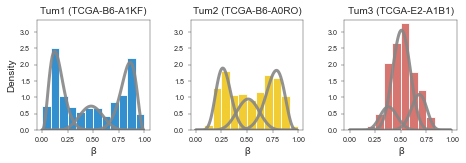

In [125]:
from scipy.stats import beta

patient_list = {'Tum1':'TCGA-B6-A1KF',
               'Tum2':'TCGA-B6-A0RO',
               'Tum3':'TCGA-E2-A1B1'}

fig, axes = plt.subplots(1, len(patient_list), figsize=np.array(figsize) * [2.3, 0.8] * sf)
fig.tight_layout(pad=0.2)

beta_values_balancedSites_TCGA = pd.read_table(os.path.join(TCGA_clinical_dir, 'cohort1.methyl.balancedSites.tsv'),
                      index_col=0).rename(columns=epi_util.sampleToPatientID)
alpha = pd.read_table(os.path.join(beta_peak_indir,
                                   'TCGA',
                                   'readable_tables',
                                   'alpha.txt'), sep=' ').rename(index=epi_util.sampleToPatientID)
delta = pd.read_table(os.path.join(beta_peak_indir,
                                   'TCGA',
                                   'readable_tables',
                                   'delta.txt'), sep=' ').rename(index=epi_util.sampleToPatientID)
tau = pd.read_table(os.path.join(beta_peak_indir,
                                 'TCGA',
                                 'readable_tables',
                                 'tau.txt'), sep=' ').rename(index=lambda x:epi_util.sampleToPatientID(x.replace('.', '-')))

chosen_tumor_colors = [consts['palette_jco'][i] for i in [0, 1, 3]]

for i, patient in enumerate(patient_list):
    col = i
    
    ax = axes[i]
    
    samp = patient_list[patient]
    cur_color = chosen_tumor_colors[i]
    title = f'{patient} ({samp})'
    xlabel = 'β'
    
    sns.histplot(ax=ax, x=beta_values_balancedSites_TCGA[samp], stat='density',
                color=cur_color, bins=12, alpha=opacity,
                binrange=(0, 1))
    
    ax.set_title(title, fontsize=labelfontsize * sf)
    ax.set_xlabel(xlabel, fontsize=labelfontsize * sf)
    if col == 0:
        ax.set_ylabel('Density', fontsize=labelfontsize * sf)
    else:
        ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

    frac_list = tau.loc[samp]
    
    print(frac_list)

#     y_sum = 0
    y_max = float('-Inf')
    
    for j, model in enumerate(alpha.columns):
        
        a = alpha.loc[samp, model]
        d = delta.loc[samp, model]
        
        if i == 2:
            print(model)
            print(a)
            print(d)
            print()

        x = np.linspace(0, 0.99, 100)
        y = beta.pdf(x, a, d) * frac_list[j]
        ax.plot(x, y,
                lw=3, alpha=0.9, color=consts['palette_jco'][2])
        
        y_max = max(y_max, max(y))
        
#         y_sum += y
        
#     ax.plot(x, y_sum, lw=2, alpha=0.4, color='black')

for i in range(len(patient_list)):
    ax = axes[i]
    ax.set_ylim(0, y_max * 1.1)

fig.savefig(os.path.join(figure_outdir, 'example_peak_decomp.pdf'), format='pdf', pad_inches=0.1)

/var/folders/m9/kv2y3r0s0p1_cl3s3py1wprh0000gn/T/ipykernel_85951/2567322947.py:7: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.swarmplot(ax=ax, data=df_combined, y = 'Mitotic Age', x = 'Dataset', hue = 'Dataset', legend=False, palette=consts['palette_jco'],


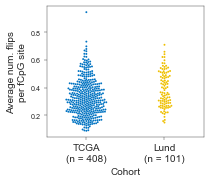

In [166]:
fig, ax = plt.subplots(figsize=figsize * sf)

df_ch1 = pd.DataFrame({'Mitotic Age':clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'mitotic_age'].dropna(), 'Dataset':'TCGA'})
df_ch2 = pd.DataFrame({'Mitotic Age':clinical['Ringner'].loc[clinical['Ringner']['in_analysis_dataset'], 'mitotic_age'].dropna(), 'Dataset':'Lund'})
df_combined = pd.concat([df_ch1, df_ch2], axis=0)

sns.swarmplot(ax=ax, data=df_combined, y = 'Mitotic Age', x = 'Dataset', hue = 'Dataset', legend=False, palette=consts['palette_jco'],
             s=12 * sf**2)
ax.set_xlabel('Cohort', fontsize=labelfontsize * sf)
ax.set_ylabel('Average num. flips\nper fCpG site', fontsize=labelfontsize * sf)
ax.set_xticks(ax.get_xticks(),
                  [group + f'\n(n = {(df_combined["Dataset"] == group).sum()})' for group in ['TCGA', 'Lund']])
ax.tick_params(axis='x', labelsize=labelfontsize * sf, width=sf, length=8 * sf)
ax.tick_params(axis='y', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

# patches = [
#     mpatches.Patch(color=consts['palette_jco'][0], label='Cohort T1'),
#     mpatches.Patch(color=consts['palette_jco'][1], label='Cohort T2')
# ]

# plots_botLeft, plots_topRight = ax.get_position().get_points()
# center_x = (plots_botLeft[0] + plots_topRight[0])/2
# center_y = (plots_botLeft[1] + plots_topRight[1])*2/3

# fig.legend(
#     handles=patches,
#     title='Dataset',
#     loc='center', bbox_to_anchor=(center_x, center_y))

fig.savefig(os.path.join(figure_outdir, 'mitotic_age.pdf'), format='pdf', pad_inches=0.1)

In [127]:
predictors = ['Stroma', 'Lipid', 'IR', 'Mitotic Checkpoint', 'Mitotic Progression', 'Basal', 'Early Response', 'SR',
# 'FGA_Gain', 'FGA_Loss',
              'FGA',
              'LUMP'
             ]
response = 'spf'

train_data = clinical['Ringner'].loc[clinical['Ringner']['in_analysis_dataset'], predictors + [response]].dropna()
train_X = train_data[predictors]
train_y = train_data[response]

TCGA_X = clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], predictors].dropna()

In [128]:
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
def myScoreFunc(model, X, y):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
#     return r2
#     n_pos = np.sum(y_pred > 0)
    pct_pos = np.mean(model.predict(TCGA_X) > 0)
#     return r2 + pct_pos * 5
    return r2 + 10 * np.all(model.predict(TCGA_X) > 0)

# eNetCV = ElasticNetCV(alphas=np.linspace(0.01, 0.99, 10), l1_ratio=np.linspace(0.01, 0.99, 10))
eNetCV = GridSearchCV(ElasticNet(), param_grid={'alpha':np.linspace(0.1, 3, 10), 'l1_ratio':np.linspace(0.01, 0.99, 10)},
                     scoring=myScoreFunc)
eNetCV.fit(train_X, train_y)

print(eNetCV.score(train_X, train_y))
print(eNetCV.best_score_)
print(eNetCV.best_params_)
# eNetCV.best_estimator_.coef_

10.539909705433798
10.4842117313812
{'alpha': 0.7444444444444444, 'l1_ratio': 0.01}


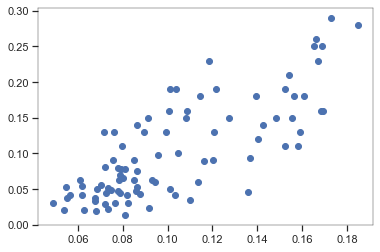

In [129]:
plt.scatter(eNetCV.predict(train_X), train_y)

Ttest_indResult(statistic=1.3995017542183033, pvalue=0.16231665968159184)


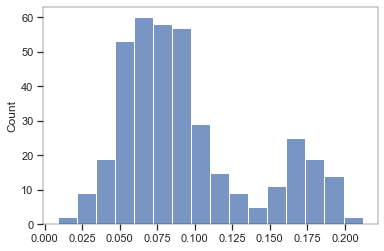

In [130]:
TCGA_y_pred = eNetCV.predict(TCGA_X)

sns.histplot(TCGA_y_pred)
from scipy.stats import ttest_ind
print(ttest_ind(train_y, TCGA_y_pred))

<Axes: xlabel='spf', ylabel='Count'>

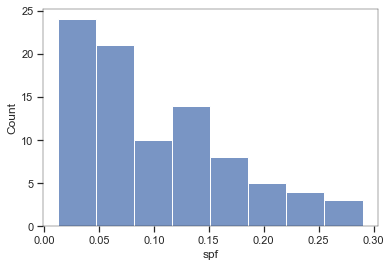

In [131]:
sns.histplot(train_y)

In [132]:
clinical['TCGA'].loc[TCGA_X.index, 'spf'] = TCGA_y_pred

In [133]:
s_phase_duration_hrs = np.mean([12.40, 11.70, 13.60, 12.95, 12.66])
s_phase_duration = s_phase_duration_hrs / 24

# Growth rate with 1 day as time unit
for dataset in dataset_list:
    clinical[dataset]['growth_rate'] = clinical[dataset]['spf'] / s_phase_duration
    clinical[dataset]['calendar_age_prod_flip_rate'] = clinical[dataset]['mitotic_age'] / clinical[dataset]['growth_rate']

<Axes: xlabel='growth_rate', ylabel='Count'>

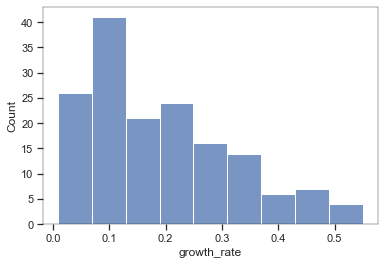

In [134]:
sns.histplot(clinical['Ringner']['growth_rate'])

In [135]:
np.mean(1 / clinical['TCGA']['growth_rate'])

6.990051525024734

In [136]:
np.mean(1 / clinical['Ringner']['growth_rate'])

9.25633376436598

In [137]:
## Flip rate

flip_rate_TCGA = clinical['TCGA'].loc['calendar_age_prod_flip_rate'].median() / (3 * 365)
flip_rate_Ringner = clinical['Ringner'].loc['calendar_age_prod_flip_rate'].median() / (3 * 365)

print(f'Cohort T1-predicted flip rate: {flip_rate_TCGA}')
print(f'Cohort T2-predicted flip rate: {flip_rate_Ringner}')

Cohort T1-predicted flip rate: 0.001736194678277288
Cohort T2-predicted flip rate: 0.0020989876958079808


In [178]:
(clinical['TCGA']['calendar_age_prod_flip_rate'] / (clinical['TCGA']['calendar_age_prod_flip_rate'].median() / 3)).median()

3.0

In [186]:
n_samps_TCGA

408

In [187]:
n_samps_Ringner

101

In [191]:
(~clinical['TCGA']['calendar_age_prod_flip_rate'].isna() & clinical['TCGA']['in_analysis_dataset']).sum()

387

In [193]:
(~clinical['Ringner']['calendar_age_prod_flip_rate'].isna() & clinical['Ringner']['in_analysis_dataset']).sum()

92

In [198]:
combined_intermed_df = pd.concat([clinical['TCGA'][['in_analysis_dataset', 'calendar_age_prod_flip_rate']],
clinical['Ringner'][['in_analysis_dataset', 'calendar_age_prod_flip_rate']]],
          axis=0)
flip_rate_est = combined_intermed_df.loc[combined_intermed_df['in_analysis_dataset'],
                                         'calendar_age_prod_flip_rate'].median() / (3 * 365)
flip_rate_est

0.0017578551969845704

In [138]:
n_samps_TCGA = clinical['TCGA']['in_analysis_dataset'].sum()
n_samps_Ringner = clinical['Ringner']['in_analysis_dataset'].sum()
flip_rate_est = (flip_rate_TCGA * n_samps_TCGA + flip_rate_Ringner * n_samps_Ringner) / (n_samps_TCGA + n_samps_Ringner)

In [179]:
flip_rate_est

0.0018081830766478186

In [185]:
pd.Series(np.concatenate([clinical['TCGA']['calendar_age_prod_flip_rate'],
                clinical['Ringner']['calendar_age_prod_flip_rate']])).dropna().median() / (3 * 365)

0.001780491552742159

In [169]:
epi_util.wilcoxonRankSums(clinical['TCGA']['mitotic_age'], clinical['Ringner']['mitotic_age'])
epi_util.wilcoxonRankSums(clinical['TCGA']['calendar_age_years'].dropna(), clinical['Ringner']['calendar_age_years'].dropna())

RanksumsResult(statistic=-4.572900852062657, pvalue=4.810177892417978e-06)

In [174]:
clinical['TCGA']['calendar_age_years'].median()

2.880562318107761

In [175]:
clinical['Ringner']['calendar_age_years'].median()

3.4824809327924084

/var/folders/m9/kv2y3r0s0p1_cl3s3py1wprh0000gn/T/ipykernel_85951/1373763478.py:32: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.swarmplot(ax=ax, data=df_combined, y='calendar_age_years', x='cohort',


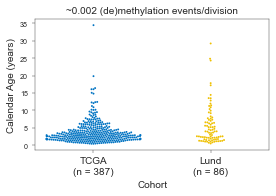

In [165]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=figsize * [1.5, 1] * sf)

clinical['TCGA']['calendar_age_years'] = clinical['TCGA']['calendar_age_prod_flip_rate'] / flip_rate_est / 365
clinical['Ringner']['calendar_age_years'] = clinical['Ringner']['calendar_age_prod_flip_rate'] / flip_rate_est / 365


df_ch1 = pd.DataFrame({'calendar_age_years':clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'calendar_age_years'],
                       'Size':clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'T Stage'],
                       'cohort':'TCGA'}).dropna()
df_ch2 = pd.DataFrame({'calendar_age_years':clinical['Ringner'].loc[clinical['Ringner']['in_analysis_dataset'], 'calendar_age_years'],
                       'Size':clinical['Ringner'].loc[clinical['Ringner']['in_analysis_dataset'], 'size'],
                       'cohort':'Lund'}).dropna()
df_combined = pd.concat([df_ch1, df_ch2], axis=0)
# df_combined = df_ch2


#####
'''
#Create a matplotlib colormap from the sns seagreen color palette
cmap = sns.light_palette("seagreen", reverse=False, as_cmap=True )
# Normalize to the range of possible values from df["c"]
norm = matplotlib.colors.Normalize(vmin=df_combined["Size"].min(), vmax=df_combined["Size"].max())
# create a color dictionary (value in c : color from colormap) 
colors = {}
for cval in df_combined["Size"]:
    colors.update({cval : cmap(norm(cval))})
    '''
#####

sns.swarmplot(ax=ax, data=df_combined, y='calendar_age_years', x='cohort',
              hue='cohort', palette=consts['palette_jco'],
              legend=False,
             s=12 * sf**2)
ax.set_xlabel('Cohort', fontsize=labelfontsize * sf)
ax.set_ylabel('Calendar Age (years)', fontsize=labelfontsize * sf)
ax.set_title(f'~{flip_rate_est:.3f} (de)methylation events/division', fontsize=labelfontsize * sf)
ax.set_xticks(ax.get_xticks(),
                  [group + f'\n(n = {(df_combined["cohort"] == group).sum()})'
                   for group in ['TCGA', 'Lund']])
ax.tick_params(axis='x', labelsize=labelfontsize * sf, width=sf, length=8 * sf)
ax.tick_params(axis='y', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)


'''
divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
fig.add_axes(ax_cb)
cb1 = matplotlib.colorbar.ColorbarBase(ax_cb, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
cb1.set_label('Size (mm)')
'''


fig.savefig(os.path.join(figure_outdir, 'calendar_age.pdf'), format='pdf', pad_inches=0.1)

In [37]:
epi_util.pearsonCorrelation(df_ch2['Calendar Age'], df_ch2['Size'])

LinregressResult(slope=-0.9080016349075366, intercept=31.13922151480366, rvalue=-0.378471721658297, pvalue=0.0003267970813558546, stderr=0.24229415014042024, intercept_stderr=2.051592783696381)

In [233]:
df_ch1.groupby('Size')['Calendar Age'].mean()

Size
T1    5.021818
T2    3.804174
T3    2.578735
T4    3.347601
TX    1.455012
Name: Calendar Age, dtype: float64

<Axes: xlabel='V2', ylabel='Count'>

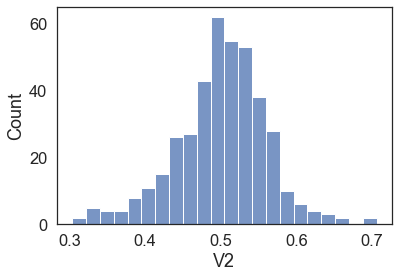

In [220]:
modes = pd.read_csv(os.path.join(beta_peak_indir,
                                             'TCGA',
                                           'readable_tables',
                                           'modes.txt'), sep=' ')
sns.histplot(modes['V2'])

<Axes: xlabel='V2', ylabel='Count'>

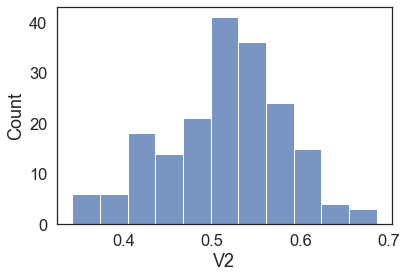

In [19]:
modes = pd.read_csv(os.path.join(beta_peak_indir,
                                             'Ringner',
                                           'readable_tables',
                                           'modes.txt'), sep=' ')
sns.histplot(modes['V2'])

In [23]:
clinical['Ringner']['middle_mode'] = modes['V2']

In [21]:
modes

,V1,V2,V3
GSM1941862,0.184802,0.450006,0.762204
GSM1941863,0.260572,0.457527,0.674866
GSM1941864,0.208212,0.497759,0.774748
GSM1941865,0.343519,0.558180,0.667033
GSM1941866,0.270288,0.559414,0.793674
...,...,...,...
GSM1942045,0.286699,0.559628,0.794940
GSM1942046,0.224667,0.391188,0.796051
GSM1942047,0.317243,0.577032,0.718690
GSM1942048,0.345114,0.492511,0.749177


In [28]:
(clinical['Ringner']['in_analysis_dataset'] & ~clinical['Ringner']['spf'].isna()).sum()

92

In [27]:
(~clinical['Ringner']['spf'].isna() & clinical['Ringner']['in_analysis_dataset'] & (clinical['Ringner']['middle_mode'] < 0.6) & (clinical['Ringner']['middle_mode'] > 0.4)).sum()

80